In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from glob import glob
from espnet.nets.pytorch_backend.e2e_asr import pad_list
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.nn.functional as F
from espnet.nets.pytorch_backend.nets_utils import get_subsample

import logging
import six

import numpy as np
import torch
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence
from torch.nn.utils.rnn import pad_packed_sequence

from espnet.nets.e2e_asr_common import get_vgg2l_odim
from espnet.nets.pytorch_backend.nets_utils import make_pad_mask
from espnet.nets.pytorch_backend.nets_utils import to_device
import torch.optim as optim
from torch.distributions import Categorical
import matplotlib.pyplot as plt

/home/neo/espnet/tools/venv/lib/python3.8/site-packages/chainer/backends/cuda.py:142: UserWarning: cuDNN is not enabled.
Please reinstall CuPy after you install cudnn
(see https://docs-cupy.chainer.org/en/stable/install.html#install-cudnn).
  warnings.warn(


In [2]:
class ASRPerfMonitorDataset(Dataset):
    def __init__(self, data_dir):
        self.npy_files = glob(f'{data_dir}/*.npy')

    def __len__(self):
        return len(self.npy_files)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        contents = np.load(self.npy_files[idx], allow_pickle = True)
        x = torch.from_numpy(contents.item().get('logits_history'))
        y = torch.tensor(contents.item().get('cer')[0])
        sample = {'logits': x, 'cer': y}
        return sample

In [57]:
asr_perf_dataset = ASRPerfMonitorDataset('/home/neo/Desktop/projects/perf_monitor/train/')

In [58]:
windows = [1,2,3,4,5]

In [59]:
logits = asr_perf_dataset[10]['logits']

In [60]:
def symmetric_kl_div(a, b):
    a = F.softmax(a, dim=0)
    b = F.softmax(b, dim=0)
    return F.kl_div(a, b) + F.kl_div(b, a)

In [61]:
x = []
y = []
for idx in range(len(asr_perf_dataset.npy_files)):
    data = asr_perf_dataset[idx]
    logits = data['logits']
    cer = data['cer'].numpy().tolist()
    if cer != 0:
        mcd = 0
        norm = 1
        for ws in windows:
            a1 = 0
            for i in range(ws, len(logits)):
                a1 += symmetric_kl_div(logits[i-ws], logits[i])
            mcd += a1
            norm += (len(logits) - ws)
        m_score = mcd / norm
        x.append(m_score)
        y.append(cer)

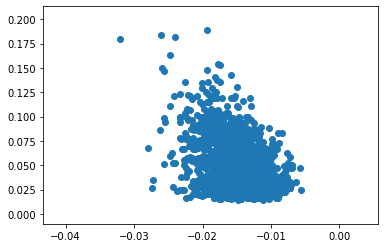

In [62]:
plt.scatter(x, y)

In [63]:
from sklearn.linear_model import LinearRegression

In [79]:
x = np.array(x)
x = np.expand_dims(x, axis=1)
y = np.array(y)

In [80]:
reg = LinearRegression().fit(x, y)

In [81]:
reg.score(x,y)

0.16433137819808408

In [84]:
yy = reg.predict(x)

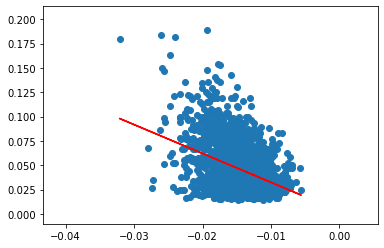

In [85]:
plt.scatter(x, y)
plt.plot(x, yy, color='red')